In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import os
import glob
import wandb
from absl import app
from absl import flags
import tensorflow as tf
from wandb.keras import WandbCallback
from ml_collections.config_flags import config_flags

# Import modules
from configs import get_config
from data import download_dataset, preprocess_dataset, GetDataloader
from models import SimpleSupervisedModel
from callbacks import GetCallbacks
from pipeline import SupervisedPipeline

In [54]:
# Get configs
configs = get_config()
configs

dataset_config:
  apply_one_hot: true
  apply_resize: true
  batch_size: 64
  channels: 3
  do_cache: true
  image_height: 224
  image_width: 224
  num_classes: 200
seed: 0
train_config:
  backbone: resnet50
  dropout_rate: 0.5
  early_patience: 6
  epochs: 20
  l2_regularizer: 0.001
  learning_rate: 0.001
  loss: categorical_crossentropy
  momentum: 0.9
  optimizer: adam
  post_gap_dropout: true
  reg: 0.0001
  regularize_backbone: false
  resume: false
  rlrp_factor: 0.2
  rlrp_patience: 3
  use_pretrained_weights: true
wandb_config:
  entity: wandb_fc
  project: ssl-study

In [55]:
# Load the dataframes
train_df = download_dataset('train', 'labelled-dataset')
valid_df = download_dataset('val', 'labelled-dataset')

# Preprocess the DataFrames
train_paths, train_labels = preprocess_dataset(train_df)
valid_paths, valid_labels = preprocess_dataset(valid_df)

# Build dataloaders
dataset = GetDataloader(configs)
trainloader = dataset.dataloader(train_paths, train_labels, dataloader_type='train')
validloader = dataset.dataloader(valid_paths, valid_labels, dataloader_type='valid')

In [56]:
# Debug Dataloaders
from utils import ShowBatch

2022-05-24 20:04:17.508592: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


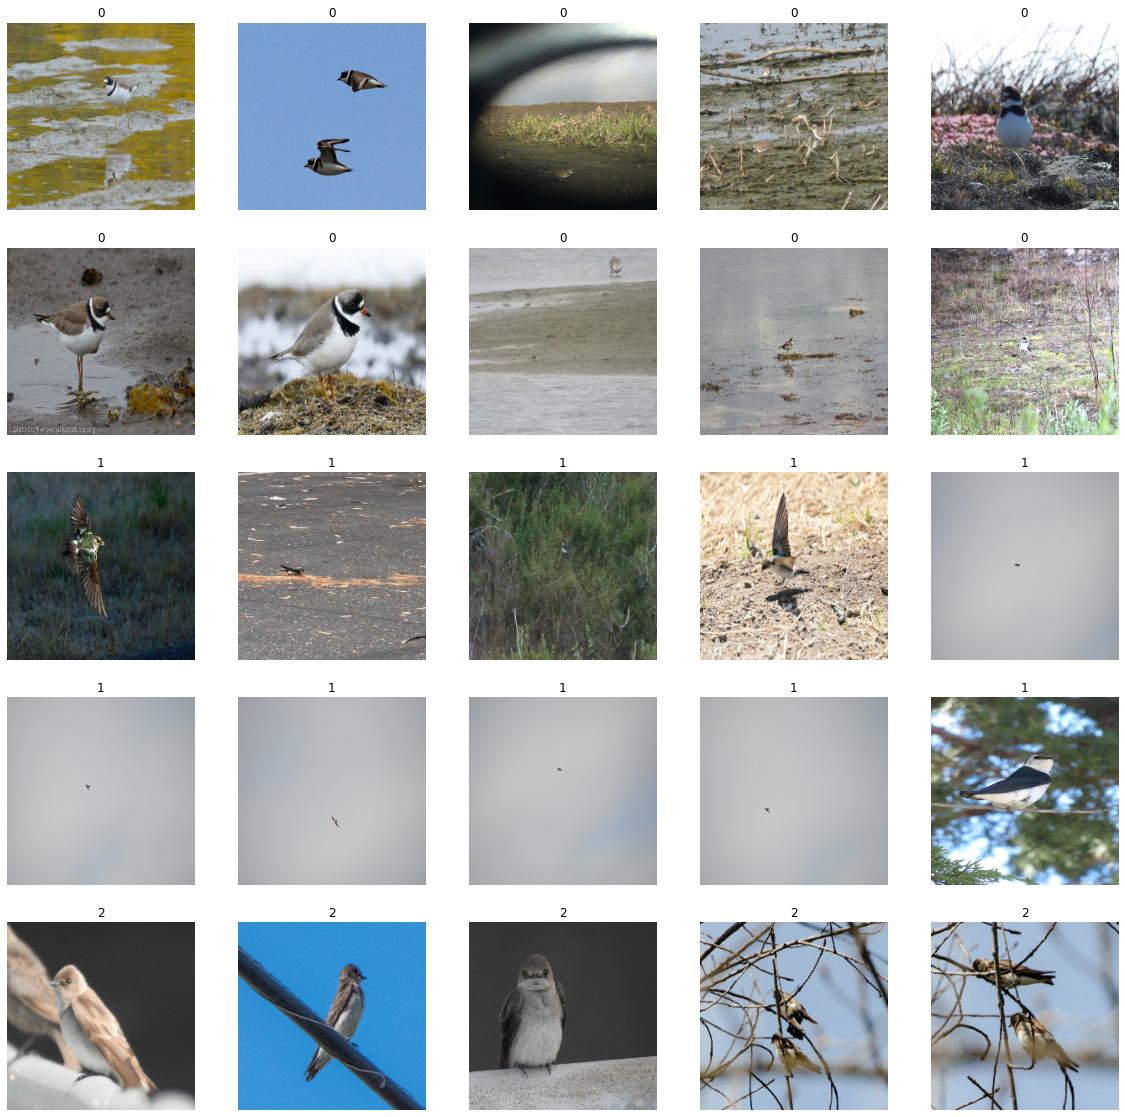

In [57]:
show_batch = ShowBatch(configs)
sample_imgs, sample_labels = next(iter(validloader))
show_batch.show_batch(sample_imgs, sample_labels)

In [58]:
# Build the model
tf.keras.backend.clear_session()
model = SimpleSupervisedModel(configs).get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)               409800    
                                                                 
Total params: 23,997,512
Trainable params: 23,944,392
Non-trainable params: 53,120
____________________________________________

In [59]:
# Build pipeline
pipeline = SupervisedPipeline(model, configs, [])

In [60]:
# Train and Evaluate
pipeline.train_and_evaluate(trainloader, validloader)

Epoch 1/20
62/62 [==============================] - 20s 249ms/step - loss: 5.3604 - top@1_acc: 0.0157 - top@5_acc: 0.0621 - val_loss: 5.3362 - val_top@1_acc: 0.0115 - val_top@5_acc: 0.0600
Epoch 2/20
62/62 [==============================] - 14s 232ms/step - loss: 4.9761 - top@1_acc: 0.0298 - top@5_acc: 0.1157 - val_loss: 5.2617 - val_top@1_acc: 0.0220 - val_top@5_acc: 0.0810
Epoch 3/20
62/62 [==============================] - 14s 232ms/step - loss: 4.7273 - top@1_acc: 0.0442 - top@5_acc: 0.1556 - val_loss: 5.2925 - val_top@1_acc: 0.0215 - val_top@5_acc: 0.0905
Epoch 4/20
62/62 [==============================] - 14s 231ms/step - loss: 4.4875 - top@1_acc: 0.0616 - top@5_acc: 0.2061 - val_loss: 5.2924 - val_top@1_acc: 0.0240 - val_top@5_acc: 0.1080
Epoch 5/20
62/62 [==============================] - 14s 231ms/step - loss: 4.1805 - top@1_acc: 0.0935 - top@5_acc: 0.2796 - val_loss: 5.3682 - val_top@1_acc: 0.0285 - val_top@5_acc: 0.1165
Epoch 6/20
62/62 [==============================] - 14s